In [1]:
%load_ext autoreload
import sys
import os
import numpy as np
import sets
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tinydb
from tinydb import Query


SPARTAN_SOURCE_DIR = os.getenv('SPARTAN_SOURCE_DIR')
sys.path.append(os.path.join(SPARTAN_SOURCE_DIR, 'src/ContactParticleFilter/python'))

import lcm
import experimentanalyzer
import utils as cpfUtils
import spartan.utils.utils as spartanUtils

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: the sets module is deprecated
  """


In [2]:
# logFolderName="20180105-165005_simulation"


configFilename = os.path.join(cpfUtils.getCPFSourceDir(), 'config', 'experiments', 'cpf_experiment_config.yaml')
config = spartanUtils.getDictFromYamlFilename(configFilename)

pose_names = config["poses"]
force_names = config["force_names"]
noise_levels = config["noise_levels"]

In [11]:
# pose_names = sets.Set()
# force_names = sets.Set()
# for entry in ea.db_analysis.all():
#     pose_names.add(entry['pose_name'])
#     force_names.add(entry['force_name'])

color = ['r','g','b']

"""
Make heatmap of average position error.
x-axis: contact location
y-axis: robot pose

should be three tables, one for each noise level 
"""
def contact_location_accuracy_heatmap(pose_names, force_names, db_analysis, noise_levels, **kwargs):
    num_poses = len(pose_names)
    num_forces = len(force_names)
    bar_width = 0.7/num_poses
    
    template = np.zeros([num_forces, num_poses])
    
    pos = dict()
    force = dict()
    
#     std_dev = dict()
#     std_dev = np.zeros([num_forces, num_poses])
    
    
    
    force_val = np.zeros([num_forces, num_poses])
    force_std_dev = np.zeros([num_forces, num_poses])
    
    
#     width_ratios = [1]*len(noise_levels)
#     width_ratios.append(0.08)
#     pos_fix, pos_ax = plt.subplots(1, len(noise_levels)+1, gridspec_kw={'width_ratios':width_ratios})
       
    for k, noise_level in enumerate(noise_levels):
        pos[noise_level] = np.copy(template)
        force[noise_level] = np.copy(template)
        pos_vals = pos[noise_level]
        force_vals = force[noise_level]
        for j, pose_name in enumerate(pose_names):
            for i, force_name in enumerate(force_names):
                q = tinydb.Query()
                res = db_analysis.search( (q.pose_name == pose_name) & (q.force_name == force_name)
                                           & (q.noise_level == noise_level) )[0]
                pos_vals[i,j] = res['stats']['position']['mean']
#                 std_dev[i,j] = res['stats']['position']['std_dev']

                force_vals[i,j] = res['stats']['force']['mean']
#                 force_std_dev[i,j] = res['stats']['force']['std_dev']

            
    # now actually make the plots
    makeSubplotAcrossNoiseLevels(pos, noise_levels, **kwargs)
    makeSubplotAcrossNoiseLevels(force, noise_levels, **kwargs)

    
"""
Takes data in dict/numpy_array form and makes a nice plot
"""
def makeSubplotAcrossNoiseLevels(data, noise_levels, xlabel="pose", ylabel="force location", addTitles=True):
    width_ratios = [1]*len(noise_levels)
    width_ratios.append(0.08)
    fig, axes = plt.subplots(1, len(noise_levels)+1, gridspec_kw={'width_ratios':width_ratios})
    
    # now we make the plots
    kwargs = dict()
    kwargs['linewidths'] = 0.5
#     kwargs['square'] = True
    axcb = axes[-1]
    axes[0].get_shared_y_axes().join(*axes[0:-1])
    for k, noise_level in enumerate(noise_levels):
        ax = axes[k]
        
        # special logic it's the rightmost one
        if k == (len(noise_levels) - 1):
            g = sns.heatmap(data[noise_level], cmap="YlGnBu", ax=ax, cbar=True, cbar_ax=axcb, **kwargs)
            
        else:
            g = sns.heatmap(data[noise_level], cmap="YlGnBu", cbar=False, ax=ax ,  **kwargs)    
        
        g.set_xlabel(xlabel)
        
        if addTitles:
            title = "Noise " + str(noise_level)
            g.set_title(title)
        
        if k == 0:
            g.set_ylabel(ylabel)
        
        if k > 0:
            g.set_yticks([])
    
    



# Simulation Fixed Base Figures
We should make several heatmaps showing the results for simulation from the kuka
- Contact location accuracy for each (force_location, robot_pose) pair
- Contact Force Accuracy for each (force_location, robot_pose) pair

In [4]:
# simulation, fixed base, load the data
simLogFolderName="20180111-161321_simulation"
ea_sim = experimentanalyzer.ExperimentAnalyzer(logFolderName=simLogFolderName)
ea_sim.run()

# hardwareLogFolderName ="20180112-161516_hardware"
# ea_hardware = experimentanalyzer.ExperimentAnalyzer(logFolderName=hardwareLogFolderName, mode="hardware")
# ea_hardware.run()

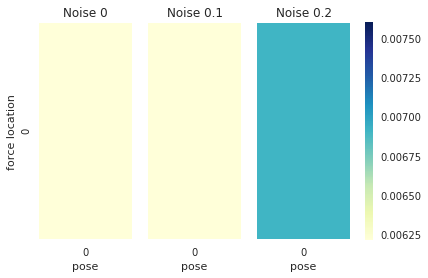

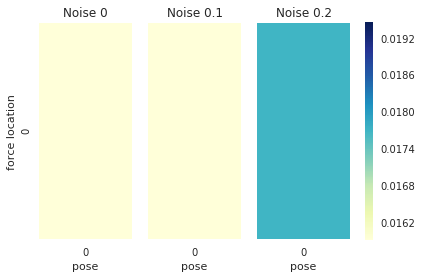

In [6]:
# make figures
contact_location_accuracy_heatmap(pose_names, force_names, ea_sim.db_analysis, noise_levels)

# Simulation Floating Base

In [7]:
# load the data for a simulation run with Floating base
logFolder = None

# Hardware

In [8]:
# load the data for hardware run
# simulation, fixed base, load the data

hardwareLogFolderName ="20180112-161516_hardware"
ea_hardware = experimentanalyzer.ExperimentAnalyzer(logFolderName=hardwareLogFolderName, mode="hardware")
ea_hardware.run()

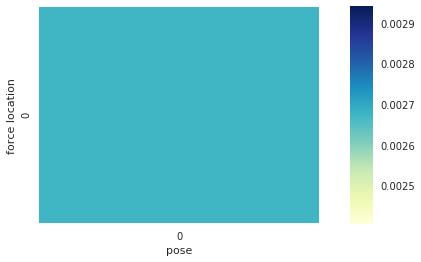

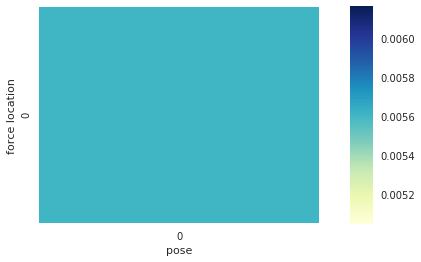

In [12]:
# make figures
contact_location_accuracy_heatmap(pose_names, force_names, ea_sim.db_analysis, noise_levels=[0], addTitles=False)